In [9]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
# Suppress annoying harmless error.
warnings.simplefilter('ignore')

# Comparing LSA, LDA, and NNMF

Now that you've been introduced to the logic behind these three topic extraction methods, we're going to try them out on the *Emma* corpus.  We'll be looking at interpretability, speed, and consistency across methods.  The goal is to identify common themes in *Emma* on a per-paragraph basis.  We won't be using pLSA as sklearn does not support it.

To do this, we will:

1. Parse and process the data into a tf-idf matrix.
2. Fit LSA, LDA, and NNMF models with 5 topics each.
4. Extract the words that best describe each topic.
5. Examine the topic relationships for the words 'marriage', 'love', and 'Emma.'

## Generating the tfidf matrix

In [10]:
import nltk
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [7]:
#nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
from nltk.corpus import gutenberg
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
# Processing the data.

# from nltk.corpus import gutenberg
# import re
# from sklearn.feature_extraction.text import TfidfVectorizer


#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')
#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

# Creating the tf-idf matrix.
#vectorizer = TfidfVectorizer(stop_words='english')

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english',
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])



#Reshapes the vectorizer output into something people can read
emma_paras_tfidf_csr = emma_paras_tfidf.tocsr()

#number of paragraphs
n = emma_paras_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names_out()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*emma_paras_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = emma_paras_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', emma_paras[5])
print('Tf_idf vector:', tfidf_bypara[5])


# Getting the word list.
terms = vectorizer.get_feature_names_out()

# Number of topics.
ntopics=5

# Linking words to topics
def word_topic(tfidf,solution, wordlist):

    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)

    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str)
        topwords.loc[column]=[x for x in chosenlist]
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 10


Number of features: 1948
Original sentence: Sixteen years had Miss Taylor been in Mr . Woodhouse ' s family , less as a governess than a friend , very fond of both daughters , but particularly of Emma .
Tf_idf vector: {'particularly': 0.2814055263803092, 'fond': 0.3256846686003196, 'friend': 0.23007822220919644, 'governess': 0.36585761136372763, 'family': 0.2886681648414907, 'mr': 0.13747346829746437, 'taylor': 0.29718151210286586, 'miss': 0.1792430775601972, 'sixteen': 0.3548032284640553, 'daughters': 0.36585761136372763, 'years': 0.29417820871919326, 'woodhouse': 0.203979614808072, 'emma': 0.1318856546488206}


In addition to creating the tfidf matrix, there are two convenience functions that will help keep the code tidy when comparing models.  The first provides a list of the words that are paired with each topic.  The second gives us the best words for each topic so we can compare across methods.

## Fitting the three topic extraction models

In [15]:
# LSA

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
emma_paras_lsa = lsa.fit_transform(emma_paras_tfidf)

components_lsa = word_topic(emma_paras_tfidf, emma_paras_lsa, terms)

topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)


In [16]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics,
          doc_topic_prior=None, # Prior = 1/n_documents
          topic_word_prior=1/ntopics,
          learning_decay=0.7, # Convergence rate.
          learning_offset=10.0, # Causes earlier iterations to have less influence on the learning
          max_iter=10, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=-1, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=0
         )

emma_paras_lda = lda.fit_transform(emma_paras_tfidf)

components_lda = word_topic(emma_paras_tfidf, emma_paras_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)


In [18]:
# NNMF

from sklearn.decomposition import NMF

nmf = NMF(#alpha=0.0,
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics,
          random_state=0,
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
emma_paras_nmf = nmf.fit_transform(emma_paras_tfidf)

components_nmf = word_topic(emma_paras_tfidf, emma_paras_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

We are mostly using the default settings for each method, but explicitly printing them so it is clear what is going on and how each model can be modified.  sklearn has such nice parallel structure for its various topic extraction methods that we could probably have abstracted the code even further.

# Inspecting the topics

For each topic, we list the ten most-relevant words according to each method:

In [19]:
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])


Topic 0:
               LSA           LDA             NNMF
0         oh 97.98      ah 18.38         oh 30.17
0          yes 5.8    emma 14.49         yes 0.55
0       thank 1.79      mr 11.69       sorry 0.16
0  difference 1.69       oh 9.67  difference 0.15
0        just 1.57      said 8.8        just 0.13
0      harriet 1.5  chapter 7.76        papa 0.12
0       sorry 1.34      mrs 7.62       short 0.12
0       short 1.27    elton 7.23        week 0.11
0        papa 1.21  harriet 6.69       cried 0.11
0        cried 1.2   weston 6.03    recollect 0.1
Topic 1:
             LSA            LDA            NNMF
1       mr 63.19       mr 28.05         mr 7.95
1     emma 62.43     emma 20.62        mrs 4.65
1     said 54.09     miss 18.24     weston 3.74
1      mrs 48.58      mrs 14.55      elton 3.63
1     miss 41.81     said 14.52  knightley 3.46
1  harriet 38.26  harriet 12.83       miss 3.15
1   weston 34.49   weston 12.32  woodhouse 2.34
1    think 29.94    elton 11.55       said 1.96


A number of things are clear.  First, some topics are shared, though the order of topics varies- the 'oh' topic is first for LSA and NNMF, but second for LDA.  And second, the content of some of the topics varies considerably across methods.  This is a clear argument for using multiple methods when exploring topics.

# Sparsity

Now let's examine sparsity by looking at the distributions of loadings for the words 'marriage', 'love', 'emma', and 'oh' across the methods:

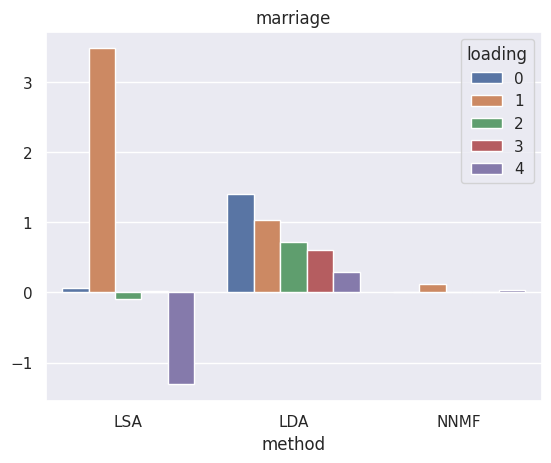

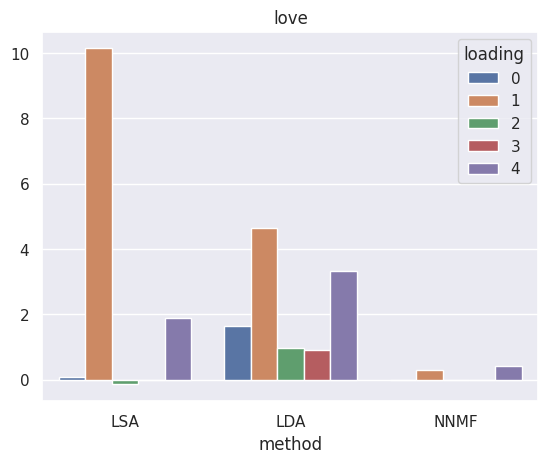

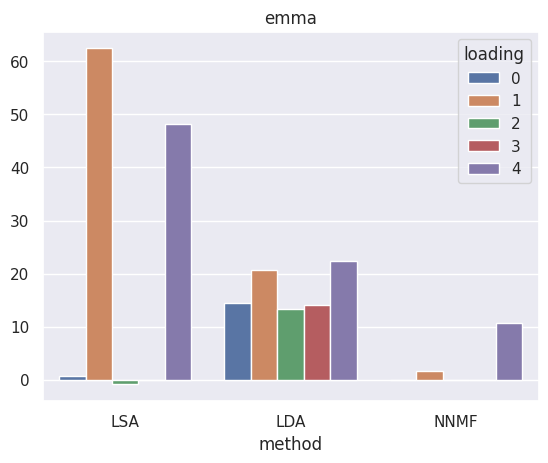

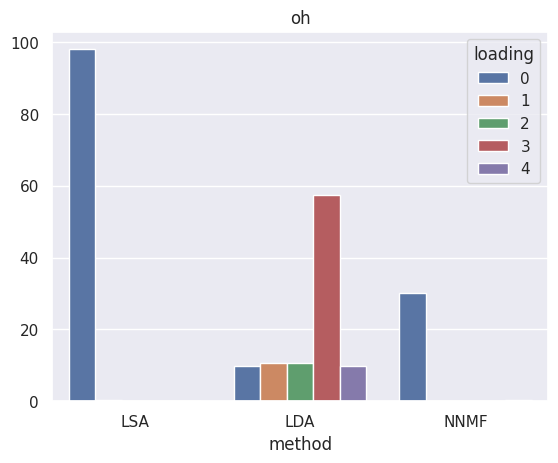

In [20]:
# The words to look at.
targetwords=['marriage','love','emma','oh']

# Storing the loadings.
wordloadings=pd.DataFrame(columns=targetwords)

# For each word, extracting and string the loadings for each method.
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

# Labeling the data by method and providing an ordering variable for graphing purposes.
wordloadings['method']=np.repeat(['LSA','LDA','NNMF'], 5, axis=0)
wordloadings['loading']=[0,1,2,3,4]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()


LSA is the method most likely to have high loadings on more than one topic for the same word.  LDA tends to have one high loading and some lower loadings.  Loadings for NNMF are lower all around, and the most sparse, with some of the topics having loadings of zero on each word.

# Challenge: Topic extraction on new data

Take the well-known [20 newsgroups](http://qwone.com/~jason/20Newsgroups/) dataset and use each of the methods on it.  Your goal is to determine which method, if any, best reproduces the topics represented by the newsgroups.  Write up a report where you evaluate each method in light of the 'ground truth'- the known source of each newsgroup post.  Which works best, and why do you think this is the case?

